In [ ]:
### ESOL predictor: GCNN, random train/validate/test splits, representation = ConvMol object (from DeepChem)

In [1]:
###load data from CSV in same folder as notebook
from deepchem.utils.save import load_from_disk
dataset_file= "./esol.csv"
dataset = load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

Columns of dataset: ['Compound ID' 'ESOL predicted log solubility in mols per litre'
 'Minimum Degree' 'Molecular Weight' 'Number of H-Bond Donors'
 'Number of Rings' 'Number of Rotatable Bonds' 'Polar Surface Area'
 'measured log solubility in mols per litre' 'smiles']
Number of examples in dataset: 1128


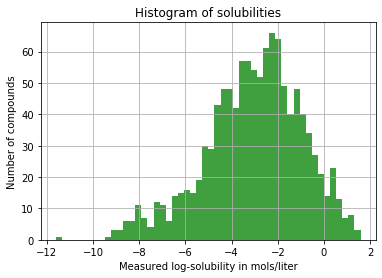

In [2]:
###plot histogram of data to show distribution
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

solubilities = np.array(dataset["measured log solubility in mols per litre"])
n, bins, patches = plt.hist(solubilities, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of solubilities')
plt.grid(True)
plt.show()

In [3]:
###featurize the data using extended connectivity fingerprints
import deepchem as dc
#featurizer = dc.feat.CircularFingerprint(size=1024)
#featurizer = dc.feat.graph_features.WeaveFeaturizer()
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], smiles_field="smiles",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./esol.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 1.090 s
TIMING: dataset construction took 1.393 s
Loading dataset from disk.


In [4]:
###randomly split data into train, validation, and test sets
splitter = dc.splits.RandomSplitter(dataset_file)
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, seed=0)

Computing train/valid/test indices
TIMING: dataset construction took 0.378 s
Loading dataset from disk.
TIMING: dataset construction took 0.181 s
Loading dataset from disk.
TIMING: dataset construction took 0.290 s
Loading dataset from disk.


In [5]:
###normalize all datasets
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.323 s
Loading dataset from disk.
TIMING: dataset construction took 0.077 s
Loading dataset from disk.
TIMING: dataset construction took 0.066 s
Loading dataset from disk.


In [6]:
###fit the model to the data
#model = dc.models.MPNNModel(n_tasks=1)
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', batch_size=50, random_seed=0, model_dir="./models/esol")

model.fit(train_dataset, nb_epoch=10, deterministic=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


C:\Users\darne\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Ending global_step 190: Average loss 1.44076
TIMING: model fitting took 12.657 s


1.440755314649141

In [ ]:
dir(model)
model.tensorboard_log_frequency

computed_metrics: [0.9177134029116422]
{'r2_score': 0.9177134029116422}


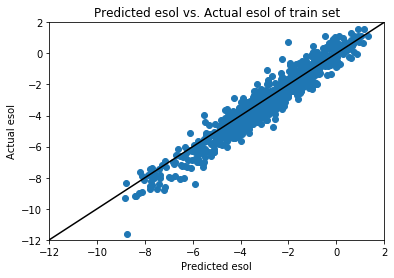

In [7]:
###evaluate the model's performance on train set
from deepchem.utils.evaluate import Evaluator
metric = dc.metrics.Metric(dc.metrics.r2_score)
evaluator = Evaluator(model, train_dataset, transformers)
r2score = evaluator.compute_model_performance([metric])
print(r2score)

### plot of train vs predicted train
predicted_train = model.predict(train_dataset)
true_train = train_dataset.y
plt.scatter(predicted_train, true_train)
plt.xlabel('Predicted esol')
plt.ylabel('Actual esol')
plt.title(r'Predicted esol vs. Actual esol of train set')
plt.xlim([-12,2])
plt.ylim([-12,2])
plt.plot([-12,2], [-12,2], color='k')
plt.show()

computed_metrics: [0.8226324961503242]
{'r2_score': 0.8226324961503242}


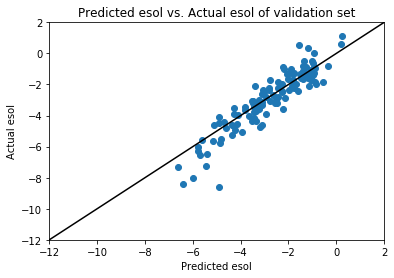

In [8]:
###evaluate the model's performance on validation set
from deepchem.utils.evaluate import Evaluator
metric = dc.metrics.Metric(dc.metrics.r2_score)
evaluator = Evaluator(model, valid_dataset, transformers)
r2score = evaluator.compute_model_performance([metric])
print(r2score)

### plot of train vs predicted validation
predicted_valid = model.predict(valid_dataset)
true_valid = valid_dataset.y
plt.scatter(predicted_valid, true_valid)
plt.xlabel('Predicted esol')
plt.ylabel('Actual esol')
plt.title(r'Predicted esol vs. Actual esol of validation set')
plt.xlim([-12,2])
plt.ylim([-12,2])
plt.plot([-12,2], [-12,2], color='k')
plt.show()

computed_metrics: [0.8441251840297376]
{'r2_score': 0.8441251840297376}


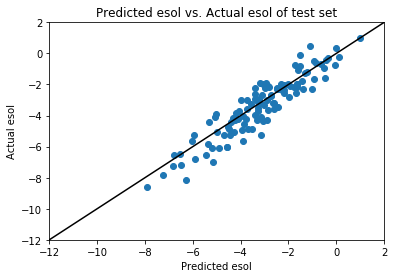

In [9]:
###evaluate the model's performance on test set
from deepchem.utils.evaluate import Evaluator
metric = dc.metrics.Metric(dc.metrics.r2_score)
evaluator = Evaluator(model, test_dataset, transformers)
r2score = evaluator.compute_model_performance([metric])
print(r2score)

### plot of train vs predicted train
predicted_test = model.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted esol')
plt.ylabel('Actual esol')
plt.title(r'Predicted esol vs. Actual esol of test set')
plt.xlim([-12,2])
plt.ylim([-12,2])
plt.plot([-12,2], [-12,2], color='k')
plt.show()

In [ ]:
model.model_dir = "./"
model.save()